# Steepest Ascent Hill Climbing

---

This notebook will train an Agent to solve the OpenAI Gym [Cartpole](https://gym.openai.com/envs/CartPole-v0/) environment using steepest ascent hill climbing.
This is a policy based method used to find the optimal policy. This algorithm is a slightly more complex than Vanilla hill climbing
but I still expect it to struggle with stability issues. I good explanation of why this algorithm fails in practice can be
found [here](https://www.javatpoint.com/hill-climbing-algorithm-in-ai). I will test this algorithm by running the simulations with different
random seeds and see how the results differ. All results will be saved in the saved_scores directory and can be viewed in
the images directory. Also comparisons between agents can be seen by using the comparisons.ipynb.

### Import the Necessary Packages

In [1]:
import gym
import numpy as np
import copy
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *


### Define the Policy Network

The policy network is what we use to transform the state into a policy. For steepest ascent hill climbing this is a very simple linear
function that is then ran through a softmax function to generate probabilities.

In [2]:
class Policy():
    """ Policy represented as Neural Network """
    def __init__(self, env, seed=0):
        """Initialize everything you need to run the policy

        :param env: environment this policy will be representing
        :param seed: for random weight generation
        """
        np.random.seed(seed)
        self.env= env
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.weights = 0.0001*np.random.rand(self.state_space, self.action_space)

    def forward_pass(self,state):
        x = np.dot(state, self.weights)
        return np.exp(x)/sum(np.exp(x)) #Softmax

    def get_action(self,state):
        probs = self.forward_pass(state)
        action = np.argmax(probs)
        return action


### Train the Agent a single time with Steepest Ascent Hill Climbing
This is a single simulation of the Steepest Ascnet  Hill Climbing algorithm.
Note that the simulation will be over when the environment is solved. (Average Score of 100 episodes > 195)

In [3]:
env = gym.make("CartPole-v0")
policy = Policy(env=env, seed=0)

def steepest_ascent(num_episodes=2000, max_time=1000, num_options=5, gamma=1.0, print_every=100, noise_scale=0.01):
    """Implementation of Single Steepest Ascent Hill Climbing. The different is that from the current policy you will
    generate num_options different policies and try them all and pick the best one. As opposed to generating 1 new policy
    from the current policy and picking it if it improves upon previous policy. So each policy will have num_options to
    choose from for its next policy.

    :param n_episodes: max number of training episodes
    :param max_t: max number of timesteps per episode
    :param num_options: This is the number of neighboring states we will consider each iteration
    :param gamma: discount rate
    :param print_every: how often to print average score
    :param noise_scale: std deviation of additive noise
    :return: list of scores from the episodes
    """
    # Setup
    scores_deque = deque(maxlen=100)
    scores = []
    best_reward = -np.inf
    best_weights = policy.weights

    for i_episode in range(1, (num_episodes+1)):
        #----------     Steepest Ascent Algorithm   ----------#
        temp_best_reward = best_reward
        prev_weights = policy.weights
        temp_best_weights = policy.weights
        
        # Run num_options episodes with different policy weights
        for option in range(num_options):
            episode_rewards = []
            # Run an enitre episode with new policy
            state = env.reset()
            policy.weights += noise_scale * np.random.rand(*policy.weights.shape) #Random noise to generate new policy
            for t in range(max_time):
                action = policy.get_action(state)
                state, reward, done, _ = env.step(action)
                episode_rewards.append(reward)
                if done:
                    break

            # Keep track of best new policy
            discounts = [gamma**i for i in range(len(episode_rewards)+1)]
            discount_reward = sum([a*b for a,b in zip(discounts, episode_rewards)])
            if discount_reward > temp_best_reward:
                temp_best_reward = discount_reward
                temp_best_weights = policy.weights
            #Reset policy for next iteration
            policy.weights = prev_weights


        # Everything else is the same as Vanilla Hill Climbing
        # Save reward from the direction we actually take (the best/steepest direction)
        scores_deque.append(temp_best_reward)
        scores.append(temp_best_reward)

        # Update Network Weights for next Episode
        if temp_best_reward > best_reward: #Found better weights
            best_reward = temp_best_reward
            best_weights = temp_best_weights
        policy.weights = best_weights

        # Show results during simulation
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0 and i_episode > 99:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            policy.w = best_weights
            break #Break out of episode loop

    return scores

scores = steepest_ascent()


Episode 100	Average Score: 101.00
Episode 200	Average Score: 111.81
Episode 300	Average Score: 124.00
Environment solved in 297 episodes!	Average Score: 195.17


### 4. Plot Single Simulation Scores

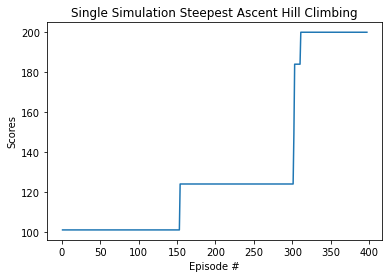

In [4]:
def graph_single(scores, save_graph=True):
    fig, ax = plt.subplots()
    ax.set(xlabel="Episode #", ylabel="Scores", title="Single Simulation Steepest Ascent Hill Climbing")
    plt.plot(np.arange(1, len(scores)+1), scores)
    if save_graph:
        filepath = f"C:\Dev\Python\RL\Policy-Based-Methods\images\\SteepestAscent_single.png"
        fig.savefig(filepath)
    plt.show()

graph_single(scores)